In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import scipy
from scipy.stats import special_ortho_group

from tqdm import tqdm
import seaborn as sns
sns.set(style="whitegrid", context="talk", font_scale=1.3)

# Optimisation problem  
$$
f(x) = x^\top A x \to \min\limits_{x \in \mathbb{R}^d}
$$

In [22]:
def quadratic_f(A, x):
    return x @ A @ x / 2

def f(A, x):
    return x @ A @ x / 2

def grad_f(A, x):
    return A @ x

def moreau_grad(y, A, kappa, x):
    return grad_f(A, y) + kappa * (y - x)

def coord_upd(y, k, A, kappa, x):
    return A[k] @ y + kappa * (y[k] - x[k])

Gilbert matrix generation
$$
H_{ij} = \dfrac{1}{i + j - 1}, \, i, j = \overline{1, n}
$$

In [4]:
d = 100
A = np.empty((d, d))
for i in range(d):
    for j in range(d):
        A[i, j] = 1 / (i+1 + j+1 - 1)

x_star = np.zeros(d)
x_0 = np.random.rand(d)

In [5]:
Lipschitz_const = abs(np.linalg.eigvals(A))
Lipsch_max = max(Lipschitz_const)

In [8]:
EPS = 1e-12

In [9]:
def grad_descent(y, x, kappa, max_k, step_size=1e-2, *args):
    n = A.shape[0]
    k = 1

    history = [y.copy()]
    
    while k <= max_k:
        y = y - step_size * moreau_grad(y, A, kappa, x)
        k += 1
        history.append(y.copy())
        if (f(A, y) - f(A, x_star)) / (f(A, history[0]) - f(A, x_star)) < EPS:
            break

    return y, history

In [11]:
%%time
x_opt, gd_history = grad_descent(x_0, x_0, 0, 100000, step_size=1/Lipsch_max)
len(gd_history)

CPU times: user 3.78 s, sys: 500 ms, total: 4.28 s
Wall time: 3.99 s


100001

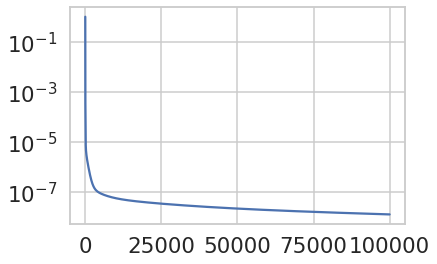

In [13]:
plt.semilogy([(f(A, x) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) for x in gd_history]);

In [14]:
def steepest_descent(y, x, kappa, max_k, step_size=1e-2, *args): # step_size = 1 / (L + kappa)
    n = A.shape[0]
    k = 1
    history = [y.copy()]
    
    while k <= max_k:
        d = moreau_grad(y, A, kappa, x)
        step_size = ((y.T @ A @ d + d.T @ A @ y) / 2 + kappa * d.T @ (y - x)) / ((d.T @ A + kappa * d.T) @ d)
        y = y - step_size * moreau_grad(y, A, kappa, x) # grad_f(A, y) # Moreau gradient correction
        k += 1

        history.append(y.copy())
        if (f(A, y) - f(A, x_star)) / (f(A, history[0]) - f(A, x_star)) < EPS:
            break

    return y, history

In [74]:
x_opt, sd_history = steepest_descent(x_0, x_0, 0, 10000, 1)
len(sd_history)

2073

In [17]:
x_opt, sd_history = steepest_descent(x_0, x_0, 0, 100000, 1)
len(sd_history)

100001

/home/eshulgin/data/mpd/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/eshulgin/data/mpd/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


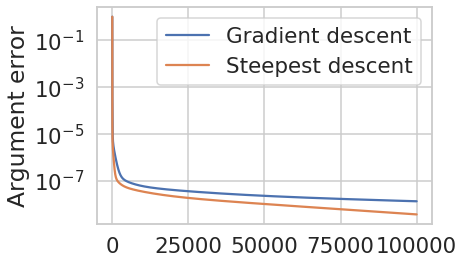

In [18]:
plt.semilogy([(f(A, x) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) 
              for x in gd_history], label='Gradient descent')
plt.semilogy([(f(A, x) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) 
              for x in sd_history], label='Steepest descent')
plt.ylabel("Argument error")
plt.legend();

In [20]:
def RACDM(y, x, kappa, max_k, L, *args):
    y = y.copy()
    y_prev = y.copy()
    
    step_sizes = (1 / L).copy()
    
    history = [y.copy()]
    k = 0
    
    while k <= max_k:
        i = np.random.randint(0, A.shape[1])
        y[i] = y[i] - step_sizes[i] * coord_upd(y, i, A, kappa, x)

        t = 0 
        while (coord_upd(y, i, A, kappa, x) * coord_upd(y_prev, i, A, kappa, x) < 0) and (t < 1000):
            t += 1
            step_sizes[i] /= 2
            y[i] = y_prev[i] - step_sizes[i] * coord_upd(y_prev, i, A, kappa, x)
            
        if t > 100:
            print(t)
        y_prev = y.copy()
        k += 1 #(1+t)
        step_sizes[i] *= 2
        history.append(y.copy())
            
    return y, history, step_sizes

In [27]:
%%time
x_opt, cd_history, step_sizes = RACDM(x_0, x_0, kappa=0, max_k=1000000, L=np.diag(A))

CPU times: user 21.5 s, sys: 824 ms, total: 22.3 s
Wall time: 22.1 s


In [28]:
%%time
RACDM_plot = [(f(A, x) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) for x in tqdm(cd_history)]

100%|██████████| 1000002/1000002 [00:21<00:00, 45593.76it/s]

CPU times: user 21.5 s, sys: 340 ms, total: 21.8 s
Wall time: 21.9 s


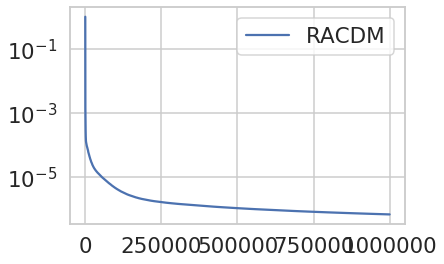

In [29]:
plt.semilogy(RACDM_plot, label='RACDM')
plt.legend();

In [30]:
def monteiro_svaiter(x_0, B_0, kappa_0, kappa_min, kappa_max, inner_method,
                     incr_coeff=3, decr_coeff=2, koef=3, max_iter=10**2, *args, **kwargs):
    z, y = x_0.copy(), x_0.copy()
    B = B_0
    kappa = kappa_0
    n = A.shape[0]
    history = [x_0.copy()]
    L = np.array([1 / kappa_0] * n)
    complexity_history = []
    kappa_list = []
    restarts = []
    
    a = (1 / kappa + np.sqrt(1 / kappa**2 + 4 * B / kappa)) / 2
    B_old = B
    B = B + a
    x = B_old / B * y + a / B * z
    
    k = 0
    while k < max_iter:
        print("  Outer iter {}".format(k))
        a = (1 / kappa + np.sqrt(1 / kappa**2 + 4 * B / kappa)) / 2
        B_old = B
        B = B + a
        x = B_old / B * y + a / B * z

        current_complexities = []
        t = 0
        while (kappa > kappa_min):
            if  (len(current_complexities) > 2) and (t > koef * (current_complexities[-2] + current_complexities[-3])/2):
                break
            if  (len(current_complexities) > 1) and (t > koef * current_complexities[-2]):
                break

            t = 0
            while (la.norm(moreau_grad(y, A, kappa, x)) > la.norm(y - x) * kappa / 2.0) and (t < 1000):
                y, inner_hist, step_sizes = inner_method(y, x, kappa, max_k=n, L=L, *args)
                L = 1 / step_sizes
                history.extend(inner_hist.copy())
                t += 1
                if (f(A, y) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) < EPS:
                    break
            print("t =", t, "Condition const: ", la.norm(moreau_grad(y, A, kappa, x)), la.norm(y - x) * kappa / 2.0)

            current_complexities.append(t)
            kappa = kappa / decr_coeff
            
            if (f(A, y) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) < EPS:
                break
        
        print("kappa = {}".format(kappa))
        print(current_complexities)
        
        z = z - a * grad_f(A, y)
        kappa = incr_coeff*kappa if incr_coeff*kappa < kappa_max else kappa
        
        k += 1
        history.append(y.copy())
        complexity_history.append(current_complexities)
        kappa_list.append(kappa)
        restarts.append(len(history))
        print()
        
        if (f(A, y) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) < EPS:
            break
    
    return y, history, complexity_history, kappa_list, restarts#points

In [51]:
2*Lipsch_max*0.8, Lipsch_max/100

(1.5981246748524363, 0.009988279217827726)

In [ ]:
# output cleared
%%time
inc_coeff = 3; dec_coeff = 2; k = 1.5
x_opt, ms_history, complexity_history, kappas, restarts = monteiro_svaiter(x_0, 0, kappa_0=2*Lipsch_max*0.8,
                                                                           kappa_min=Lipsch_max/200,
                                                                           kappa_max=Lipsch_max*10,
                                                                           inner_method=RACDM, max_iter=20,
                                                                           incr_coeff=inc_coeff, 
                                                                           decr_coeff=dec_coeff, 
                                                                           koef=k)
complexity_history, np.sum(np.sum(complexity_history)), len(ms_history)

In [33]:
%%time
MS_RACDM_plot = [(f(A, x) - f(A, x_star)) / (f(A, x_0) - f(A, x_star)) for x in tqdm(ms_history)]

100%|██████████| 61629/61629 [00:01<00:00, 40656.08it/s]

CPU times: user 1.46 s, sys: 4 ms, total: 1.47 s
Wall time: 1.52 s


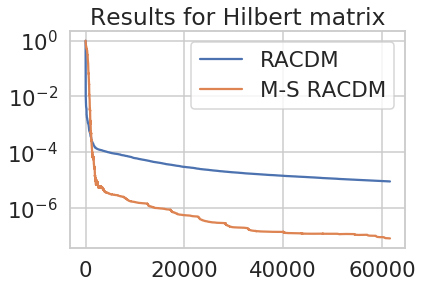

In [35]:
plt.semilogy(RACDM_plot[:len(MS_RACDM_plot)], label='RACDM')
plt.semilogy(MS_RACDM_plot[:len(RACDM_plot)], label='M-S RACDM')
plt.title("Results for Hilbert matrix")
plt.legend();